## Setup

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [3]:
%%R 

library(tidycensus)
library(tidyverse)

# store any shapefiles we grab from the census in ~/Library/Caches/tigris
# in case the government removes the shapefiles FTP server again 😭
options(tigris_use_cache = TRUE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### Step 1 \| Load Census API key from `.env` file

The `.env` file should look like this:

```bash
CENSUS_API_KEY="your-api-key-here"
```

This is what is known as an environment variable. 

We load it below in Python

In [4]:
from dotenv import load_dotenv
load_dotenv() # <- searches for a file named .env and loads the environment variables in it

True

And in this cell we pass the environment variable to tidycensus in R

In [5]:
%%R 

census_api_key(Sys.getenv("CENSUS_API_KEY")) # <- Loads CENSUS_API_KEY from environment variable and sets it in R

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Note, you probably always want population variable (B01003_001) which we found in censusreporter here: https://censusreporter.org/tables/B01003/

- find some other variables that you're also interested in
- don't forget to pick a geography like "tract", "county" or "block group". here is the list of [all geographies](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus
).

👉 use the code from the example notebooks to get the variables you're interested in. feel free to use ChatGPT for help

In [30]:
%%R 

# this code is incomplete, refer to example notebooks
# and use chat gpt for help getting census variables
nyc_census_data <- get_acs(geography = "tract", 
                      state='NY',
                      county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
                      variables = c(
                        total ="B28008_001",    #total households
                        internet = "B28008_002", # houses with internet 
                        dialup = "B28008_003", #households with dialup internet connection alone
                        no_internet = "B28008_009" # houses with no internet
                      ),
                      year = 2021,
                      survey="acs5",
                      geometry=T)

nyc_census_data

Simple feature collection with 9308 features and 5 fields (with 4 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
First 10 features:
         GEOID                                       NAME    variable estimate
1  36081014700  Census Tract 147, Queens County, New York       total     2858
2  36081014700  Census Tract 147, Queens County, New York    internet     2749
3  36081014700  Census Tract 147, Queens County, New York      dialup        0
4  36081014700  Census Tract 147, Queens County, New York no_internet       12
5  36047058400   Census Tract 584, Kings County, New York       total     3655
6  36047058400   Census Tract 584, Kings County, New York    internet     3398
7  36047058400   Census Tract 584, Kings County, New York      dialup        0
8  36047058400   Census Tract 584, Kings County, New York no_internet       95
9  36061006900 Census Tract 69, New York Co

Getting data from the 2017-2021 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'


### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [31]:
%%R 

nyc_census_data <- nyc_census_data %>% 
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  ) # pivot from wide to long

nyc_census_data

Simple feature collection with 2327 features and 10 fields (with 1 geometry empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 11
   GEOID       NAME                    geometry total_estimate internet_estimate
   <chr>       <chr>         <MULTIPOLYGON [°]>          <dbl>             <dbl>
 1 36081014700 Censu… (((-73.9137 40.76548, -7…           2858              2749
 2 36047058400 Censu… (((-73.96103 40.59616, -…           3655              3398
 3 36061006900 Censu… (((-74.02064 40.73039, -…           2126              2116
 4 36047073000 Censu… (((-73.93345 40.6257, -7…           2662              2593
 5 36047100400 Censu… (((-73.90735 40.63083, -…           3004              2965
 6 36047055700 Censu… (((-73.96279 40.72256, -…           1834              1834
 7 36005022101 Censu… (((-73.92012 40.83759, -…           4030              3790
 8 36081047000 Censu… 

### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

👉 In this step, do any calculations you need (for example if you have the total black population, but you want it as a percent of total population in a census tract, you may have to do some division)

In [32]:
%%R 

# your code here. refer to example notebooks for help
nyc_census_data <- nyc_census_data %>% 
    mutate(
        borough = str_split(NAME, ",") %>% map_chr(2) %>% str_trim()
    )

### Step 5 | Example Plots

Use histograms or dotplots to view the distributions

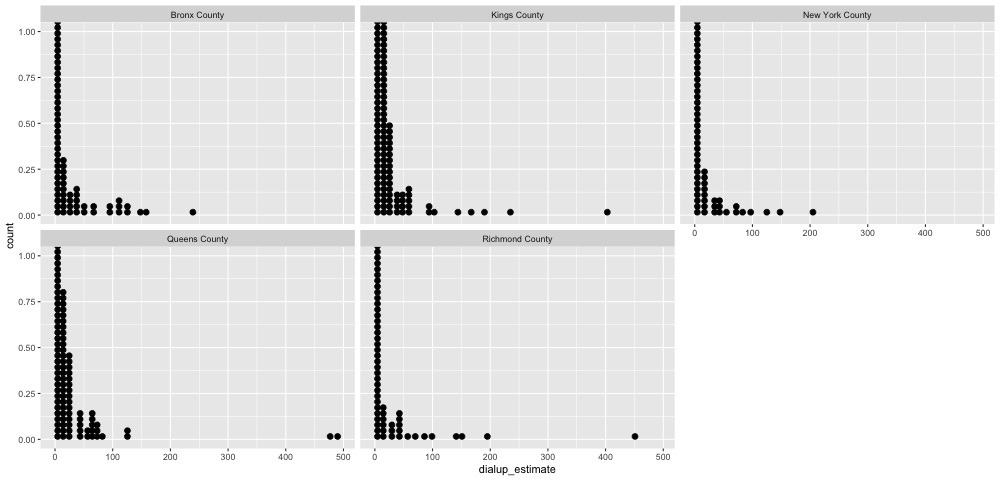

In [38]:
%%R -w 1000

ggplot(nyc_census_data) + 
    aes(x=dialup_estimate) +
    geom_dotplot(binwidth=10) + 
    facet_wrap(~borough) 


# your code here. refer to example notebooks for help


### Step 6 \| Example Map

See more details about making maps here:

https://walker-data.com/tidycensus/articles/spatial-data.html

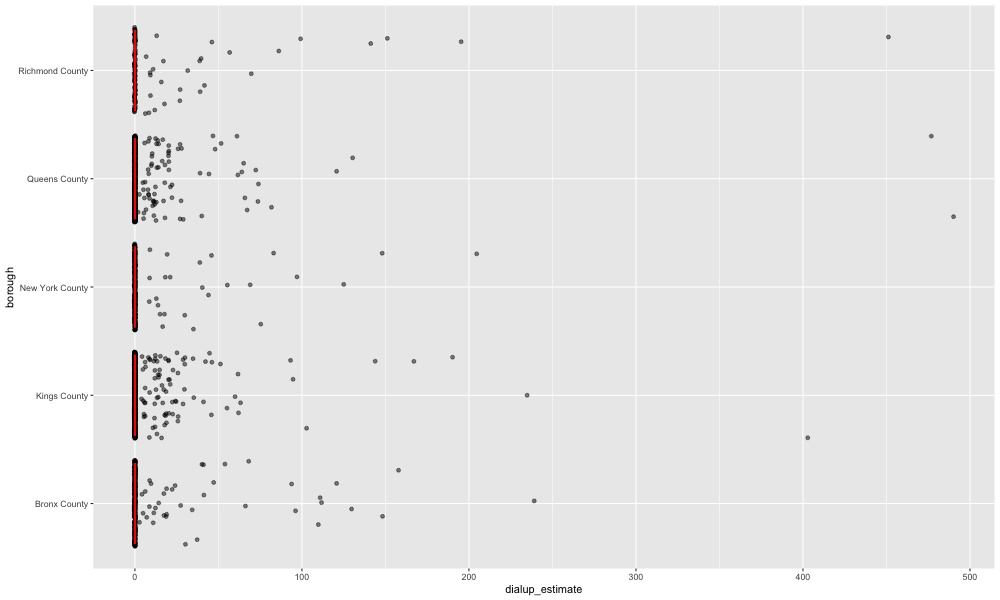

In [37]:
%%R -w 1000 -h 600

ggplot(nyc_census_data) + 
    aes(x=dialup_estimate, y=borough) +
    geom_jitter(alpha=0.5) + 
    # overlay a box and whisker plot that is transparent with no outliers and is red
    geom_boxplot(fill=NA, outlier.shape=NA, color="red") 

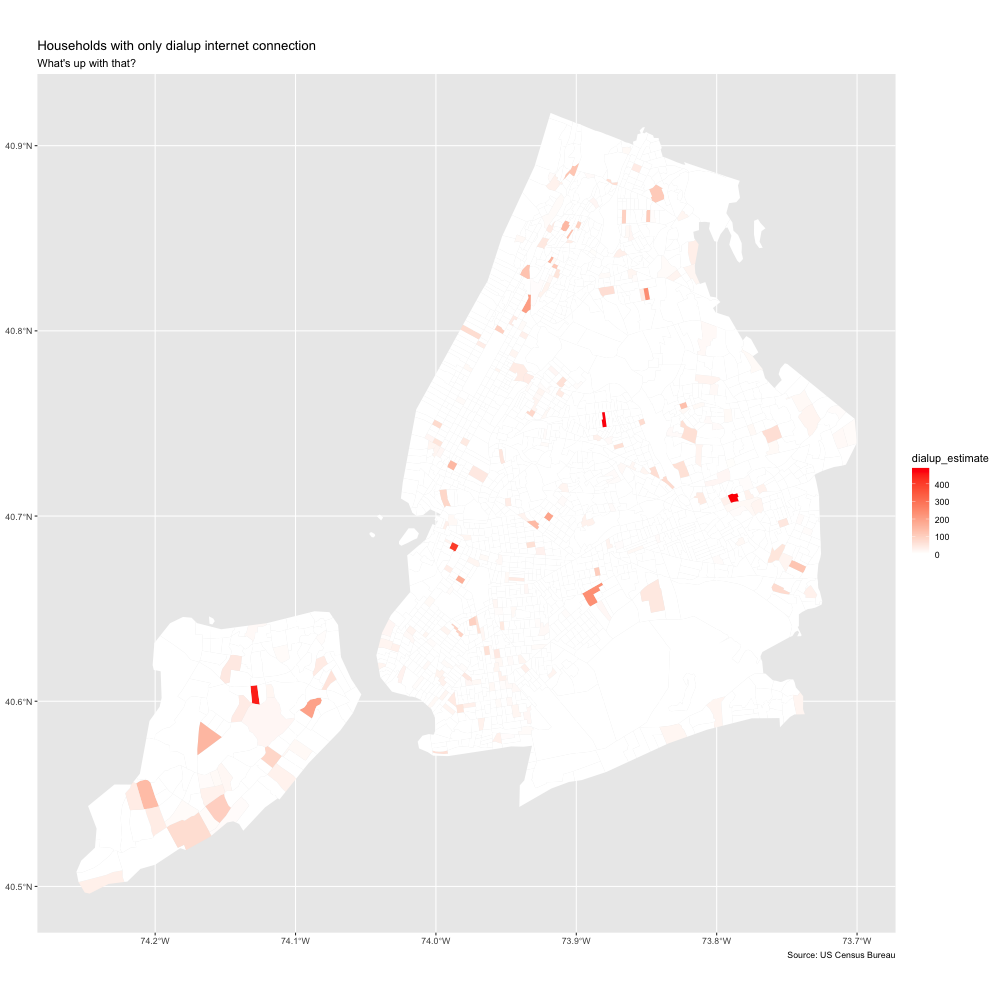

In [73]:
%%R -w 1000 -h 1000

nyc_census_data %>%
  ggplot(aes(fill = dialup_estimate)) + 
  geom_sf(color = NA) + 
  scale_fill_gradient(low="white", high="red") + 
  labs(
    title = "Households with only dialup internet connection",
    subtitle = "What's up with that?",
    caption = "Source: US Census Bureau"
  )

#### Found 4 census tracts that have the most households with just dialup internet connection (no wifi, broadband, cellular data).
#### I am trying to look for their locations/ census tract IDs from their GEOID

In [44]:
%%R

library(dplyr)


In [48]:
%%R

colnames(nyc_census_data)

 [1] "GEOID"                "NAME"                 "geometry"            
 [4] "total_estimate"       "internet_estimate"    "dialup_estimate"     
 [7] "no_internet_estimate" "total_moe"            "internet_moe"        
[10] "dialup_moe"           "no_internet_moe"      "borough"             


In [62]:
%%R

result <- nyc_census_data %>%
  filter(borough == "Kings County", dialup_estimate) %>%  
  arrange(desc(dialup_estimate)) %>%  
  slice(1)  

In [63]:
%%R

print(result$GEOID)          

[1] "36047007100"


## This is census tract 71 in Brooklyn. This tract has the most households with just a dialup internet connection (no broadband or even cellular data). What's up with that?

#### Source: https://datacommons.org/browser/geoId/36047007100

In [69]:
%%R

result_new <- nyc_census_data %>%
  filter(borough == "Queens County", dialup_estimate > 0) %>%  
  arrange(desc(dialup_estimate)) %>%  
  slice(1:3)

In [70]:
%%R

print(result_new$GEOID)

[1] "36081046200" "36081027900" "36081085500"


## These are 2 census tracts in Queens: 279 and 462 that have the most households with only dialup internet.

#### Source: https://datacommons.org/browser/geoId/36081046200, https://datacommons.org/browser/geoId/36081027900

In [71]:
%%R

result_new <- nyc_census_data %>%
  filter(borough == "Richmond County", dialup_estimate > 0) %>%  
  arrange(desc(dialup_estimate)) %>%  
  slice(1)

In [72]:
%%R

print(result_new$GEOID)

[1] "36085018703"


## This is census tract 187.03 in Staten Island with the most households that only have dialup internet.

#### Source: https://datacommons.org/browser/geoId/36085018703